In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path
import glob
import json
import pandas as pd
import re

import seaborn as sns
from latexify import latexify, format_axes

/home/fliang/.pyenv/versions/bachbot/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
EXPERIMENT_NAME = '8-1-bachbot-questions'
RESPONSES_PATH = os.path.join('/home/fliang/Dropbox/Documents/16-17/research/bachbot-paper/data', EXPERIMENT_NAME)

MASK_ORDER = ['S', 'A', 'T', 'B', 'AT', 'ATB', 'SATB']
AGE_GROUP_ORDER = ['under18', '18to25', '26to45', '46to60', 'over60']
MUSIC_EXPERIENCE_ORDER = ['novice', 'intermediate', 'advanced', 'expert']
ORDERS = {
    'maskedParts': MASK_ORDER,
    'ageGroup': AGE_GROUP_ORDER,
    'musicExperience': MUSIC_EXPERIENCE_ORDER
}

In [4]:
def exact_CI(x, N, alpha=0.95):
    """
    Calculate the exact confidence interval of a proportion 
    where there is a wide range in the sample size or the proportion.

    This method avoids the assumption that data are normally distributed. The sample size
    and proportion are desctibed by a beta distribution.

    Parameters
    ----------

    x: the number of cases from which the proportion is calulated as a positive integer.

    N: the sample size as a positive integer.

    alpha : set at 0.95 for 95% confidence intervals.

    Returns
    -------
    The proportion with the lower and upper confidence intervals as a dict.

    """
    from scipy.stats import beta
    x = float(x)
    N = float(N)
    p = round((x/N),2)

    intervals = [round(i,4) for i in beta.interval(alpha,x,N-x+1)]
    intervals.insert(0,p)

    result = {
        'Proportion': p,
        'Lower CI': np.minimum(np.maximum(0.0, intervals[1]), 1.0) - p,
        'Upper CI': np.maximum(0.0, np.minimum(1.0, intervals[2])) - p
    }

    return result

In [5]:
def get_mask(response):
    names = map(lambda c: c['name'], response['choices'])
    name = (n for n in names if re.match(".*-mask-.*|^out-.*", n)).next()
    if name[:3] == 'out':
        return 'SATB'
    else:
        parts = name[:-4].split('-')
        return ''.join(map(lambda x: x[0], parts[parts.index('mask')+1:parts.index('fermatas')]))

In [6]:
def get_name(response):
    names = map(lambda c: c['name'], response['choices'])
    orig_name = '-'.join((n for n in names if re.match(".*-nomask-.*", n)).next().split('-')[:2])
    gen_name = '-'.join((n for n in names if re.match(".*-mask-.*|^out-.*", n)).next().split('-')[:2]) \
        + '-' + get_mask(response)
    return orig_name + ' vs ' + gen_name

In [7]:
def is_correct(response):
    return response['choiceIndex'] == response['correctIndex']

In [8]:
def process_responses(responses):
    for response in responses:
        yield get_name(response), get_mask(response), is_correct(response)

In [9]:
def first_attempt_by_ip(blobs):
    return pd.DataFrame(blobs.groupby('ip').aggregate(lambda gp: gp.sort_values('datetime').iloc[0]))

In [10]:
def make_error_bars(props):
    return np.abs(np.concatenate(
        (props['Lower CI'].values[np.newaxis,:],
        props['Upper CI'].values[np.newaxis,:]),
        axis=0)[np.newaxis,:,:])
    
def make_error_bars2(props):
    return np.abs(np.swapaxes(
        np.swapaxes(
            np.concatenate(
                (props['Lower CI'].values[:,:,np.newaxis],
                props['Upper CI'].values[:,:,np.newaxis]),
                axis=2),
            0,1),
    1,2))

In [11]:
blobs = [json.load(open(fp, 'r')) for fp in glob.glob(RESPONSES_PATH + '/*')]
len(blobs)

1826

In [12]:
first_attempt_by_ip(pd.DataFrame(blobs)).shape[0]

1779

In [13]:
df = pd.DataFrame(
    [(ip, name, maskedParts, correct) + tuple(row.userInfo.values())
     for ip, row in first_attempt_by_ip(pd.DataFrame(blobs)).iterrows()
     for name, maskedParts, correct in process_responses(row.responses)],
    columns=('ip','name','maskedParts','correct','musicExperience','ageGroup'))
for col, order in ORDERS.items():
    df[col] = df[col].astype('category').cat.reorder_categories(order, ordered=True)
df.head()

,ip,name,maskedParts,correct,musicExperience,ageGroup
0,1.72.9.186:54385,BWV-276 vs BWV-276-ATB,ATB,True,advanced,26to45
1,1.72.9.186:54385,BWV-121.6 vs BWV-121.6-S,S,True,advanced,26to45
2,1.72.9.186:54385,BWV-393 vs out-60.mp3-SATB,SATB,False,advanced,26to45
3,1.72.9.186:54385,BWV-307 vs out-56.mp3-SATB,SATB,False,advanced,26to45
4,1.72.9.186:54385,BWV-310 vs BWV-310-AT,AT,True,advanced,26to45


In [14]:
len(filter(lambda x: x in ['advanced','expert'], df.musicExperience)) * 1. / df.shape[0]

0.2540753232152895

In [24]:
df\
.groupby(["ip"])\
.first()\
.head()

,name,maskedParts,correct,musicExperience,ageGroup
ip,,,,,
1.72.9.186:54385,BWV-276 vs BWV-276-ATB,ATB,True,advanced,26to45
1.75.1.176:19463,BWV-378 vs BWV-378-ATB,ATB,False,expert,46to60
1.75.1.176:19501,BWV-411 vs BWV-411-AT,AT,True,expert,46to60
1.75.1.176:19587,BWV-307 vs out-56.mp3-SATB,SATB,False,expert,46to60
1.75.232.151:63612,BWV-164.6 vs out-45.mp3-SATB,SATB,False,novice,18to25


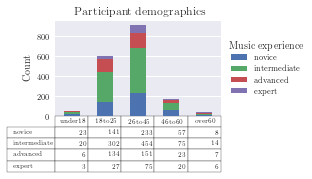

In [26]:
latexify(columns=1)

ax = df\
.groupby(["ip"])\
.first()\
.groupby(["ageGroup", "musicExperience"])\
.apply(len)\
.unstack(1)\
.loc[ORDERS['ageGroup']]\
[ORDERS['musicExperience']]\
.fillna(0)\
.plot.bar(table=True, stacked=True)
ax.set_title('Participant demographics')
ax.set_ylabel('Count')
ax.get_xaxis().set_visible(False)   # Hide Ticks

#ax.legend(title="Music experience", loc='best')
# Shrink current axis by 20%, add legend to left
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title="Music experience", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('responses-ageGroup-musicExperience.pgf', bbox_inches='tight', dpi=300)
plt.show()

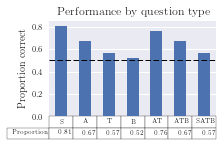

In [15]:
latexify(columns=1)

props = df\
.groupby(["maskedParts"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\

ax = props.plot.bar(
    y='Proportion',
    table=True)
    #yerr=make_error_bars(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Performance by question type')
ax.set_ylabel('Proportion correct')
ax.get_xaxis().set_visible(False)   # Hide Ticks
ax.legend().remove()

plt.tight_layout()
plt.savefig('responses-mask.pgf', bbox_inches='tight', dpi=300)
plt.show()

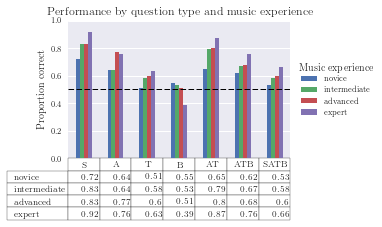

In [16]:
latexify(fig_width=4)

props = df\
.groupby(["maskedParts", "musicExperience"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\
.unstack(1)\
.loc[ORDERS['maskedParts']]

ax = props.plot.bar(
    y='Proportion',
    table=True)
    #yerr=make_error_bars2(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Performance by question type and music experience')
ax.set_ylabel('Proportion correct')
ax.set_ylim([0, 1])
ax.get_xaxis().set_visible(False)   # Hide Ticks

#ax.legend(title="Music experience", loc='best')
# Shrink current axis by 20%, add legend to left
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title="Music experience", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('responses-mask-musicExperience.pgf', bbox_inches='tight', dpi=300)
plt.show()

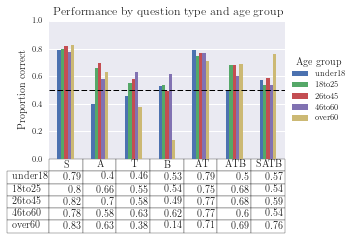

In [17]:
latexify(fig_width=4)

props = df\
.groupby(["maskedParts", "ageGroup"])\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))\
.unstack(1)\
.loc[ORDERS['maskedParts']]

ax = props.plot.bar(
    y='Proportion',
    table=True)
    #yerr=make_error_bars2(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Performance by question type and age group')
ax.set_ylabel('Proportion correct')
ax.set_ylim([0, 1])
ax.get_xaxis().set_visible(False)   # Hide Ticks

#ax.legend(title="Age group", loc='best')
# Shrink current axis by 20%, add legend to left
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title="Age group", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('responses-mask-agegroup.pgf', bbox_inches='tight', dpi=300)
plt.show()

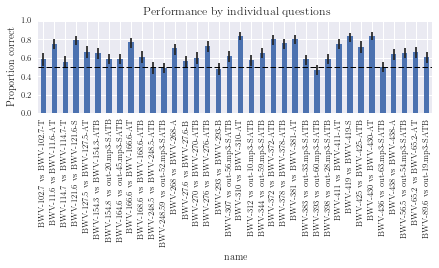

In [19]:
latexify(columns=2)

props = df\
.groupby("name")\
.apply(lambda gp: pd.Series(exact_CI(gp['correct'].sum(), gp['correct'].count(), alpha=0.95)))

ax = props.plot.bar(y='Proportion', yerr=make_error_bars(props))
ax.axhline(y=0.5, linewidth=1, color='k', ls='--')
ax.set_title('Performance by individual questions')
ax.set_ylabel('Proportion correct')
ax.set_ylim([0, 1])
ax.legend().remove()

plt.tight_layout()
plt.savefig('responses-name.pgf', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
# Proportion of questions where change in proportion correct is  statistically insignificant from baseline
df = props.loc[filter(lambda x: re.match(r".*SATB", x), props.index)]
(df.Proportion + df['Lower CI'] <= 0.50).sum() / float(df.shape[0])

0.25

In [35]:
df = pd.read_csv(
    '/home/fliang/Dropbox/Documents/16-17/research/bachbot-paper/data/Analytics All Web Site Data Location 20160701-20170222.csv','/home/fliang/Dropbox/Documents/16-17/research/bachbot-paper/data/Analytics All Web Site Data Location 20160701-20170222.csv',
    skiprows=6)\
.fillna('n/a')\
.set_index(['Country'])

/home/fliang/.pyenv/versions/bachbot/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


KeyError: 'Country'

In [32]:
df = pd.read_csv(
    '/home/fl350/data/Analytics All Web Site Data Location 20160712-20160811.csv',
    skiprows=6)\
.fillna('n/a')\
.set_index(['Country'])
df = df.assign(Percentage = lambda x: 100 * np.round(x.Sessions / df.Sessions.sum(), 2))\
.rename(columns={'Percentage': '% All Sessions'})

with open('user-countries.tex', 'wb') as f:
    f.write(df[['Sessions', '% All Sessions']].to_latex(index=True,longtable=False))
    
df

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [31]:
df_sub = df.iloc[:28]

In [30]:
latexify(fig_width=2.55, fig_height=2.55)

ax = pd.DataFrame(df_sub.Sessions).plot.pie(y='Sessions', labels=None)
ax.set_ylabel('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Add legend to left
ax.legend(title="Country", labels=df.index,
          loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('user-demographics-pie.pgf', bbox_inches='tight', dpi=300)
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
df_sub